In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics
from scipy import stats
import seaborn as sns

def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

def balanced_acc_5_cls(pred,true): 
    unique, counts = np.unique(true, return_counts=True)
    acc = 0
    for u in unique:
        pred_cls = pred[true==u]
        true_cls = true[true==u]
        acc+=metrics.accuracy_score(pred_cls,true_cls)
    #print(acc)
    return acc/unique.shape[0]

In [3]:
          
def collate_confidence(probs,num_class=5): #,pred):
    # probs: sequence of probabilities for each micro activity
    # pred: sequence of micro activity prediction
    # output: a float (not array) between 0 and 1 indicating the overall confidence of the sequence prediction
    if probs.shape[0]==num_class:
        return probs.max(axis=0)
    else:
        return probs.max(axis=1)

In [4]:

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# generate correlation plot

In [5]:
## loss model

corr_dict = {}
confidence_score = {}

df = None
healthy_df = None
activities = ['all',]
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']

primatives = {0:'idle', 1: 'reach', 2: 'reposition', 3: 'stabilize', 4: 'transport'}

for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) 
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model._stroke.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                data_dict['gt'][j] = data_dict['gt'][j].numpy() 
                data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

            probs_cal.append(data_dict['probs'])
            
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
            temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            
            if df is None:
                df=temp
            else:
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)
        
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            balanced_acc = []
            f1_score = []
            recall_score = []
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                data_dict['gt'][j] = data_dict['gt'][j] 
                data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

                probs_cal.append(data_dict['probs'])
            
                balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),))
                f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                    data_dict['probs'][j].argmax(axis=0),
                                                   average = 'macro'
                                                          )
                                    )
                recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                           data_dict['probs'][j].argmax(axis=0),
                                                           average='macro'
                                                          )
                                    )
        except Exception as e:
            print(e)
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
        temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
        temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
        temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
        temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
               
        if healthy_df is None:
            healthy_df = temp
        else:
            healthy_df = pd.concat([healthy_df,temp],ignore_index=True)

        
    prob = df.groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
    
    

all


Correlation coefficient = 0.814 
 (95% C.I. [0.700,0.888])


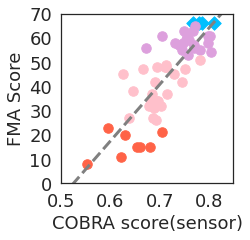

In [68]:
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)
color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = final.Severity.map(color_dict)
sns.set(style='white')
if True:
    fig, axes = plt.subplots(1,1,figsize=(3.5,3.5))
    plt.rcParams['font.family'] = 'Helvetica'
    plt.scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=90, label='healthy(held-out)')
    plt.scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=90,label='mild')
    plt.scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=90,label='moderate')
    plt.scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=90,label='severe')
#     plt.scatter(HC_confidence_by_sub.mean_non_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=90, label='healthy(held-out)')
#     plt.scatter(final[final['Severity']=='mild']['non_motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=90,label='mild')
#     plt.scatter(final[final['Severity']=='moderate']['non_motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=90,label='moderate')
#     plt.scatter(final[final['Severity']=='severe']['non_motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=90,label='severe')
    plt.xlim(0.5,0.85)
    plt.ylim(0,70)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
#     y = np.concatenate((final['non_motion'].values, HC_confidence_by_sub.mean_non_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,0.9, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
plt.xlabel('COBRA score(sensor)',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
#plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('plot/sensor_motion.pdf')

    